In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Getting data from scraped csv file

In [2]:
df = pd.read_csv("WineData.csv")
df.head()

,Unnamed: 0,Id,Name,Price,Rating,NumRatings,Type,StyleName,Year,Body,Acidity,Vintage,Nat,Region,Country,Size,Winery
0,0,1416855,Bota Box Redvolution 2011,5.02,3.5,1957,1,Californian Red Blend,2011,4,3,0,0,California,United States,500,Bota Box
1,1,88766858,Crane Lake Cabernet Sauvignon 2016,5.49,3.2,3101,1,Californian Cabernet Sauvignon,2016,4,3,0,0,California,United States,750,Crane Lake
2,2,141258254,Crane Lake Pinot Noir 2016,5.49,3.2,1466,1,Californian Pinot Noir,2016,3,3,0,0,California,United States,750,Crane Lake
3,3,157294384,Oro Bello Rosé Gold 2017,5.25,3.8,50,4,Californian Rosé,2017,3,2,0,0,California,United States,750,Oro Bello
4,4,1395988,Sutter Home White Zinfandel 2012,6.67,3.6,6112,4,NONE,2012,-1,-1,0,0,St. Helena,United States,750,Sutter Home


# Cleaning the data

In [3]:
df.columns

Index(['Unnamed: 0', 'Id', 'Name', 'Price', 'Rating', 'NumRatings', 'Type',
       'StyleName', 'Year', 'Body', 'Acidity', 'Vintage', 'Nat', 'Region',
       'Country', 'Size', 'Winery'],
      dtype='object')

In [4]:
#Drop all categorical/useless columns
numeric = df.drop(columns=['Unnamed: 0', 'Id', 'Name', 'StyleName', 'Region', 'Country', 'Winery'])
numeric.head()

,Price,Rating,NumRatings,Type,Year,Body,Acidity,Vintage,Nat,Size
0,5.02,3.5,1957,1,2011,4,3,0,0,500
1,5.49,3.2,3101,1,2016,4,3,0,0,750
2,5.49,3.2,1466,1,2016,3,3,0,0,750
3,5.25,3.8,50,4,2017,3,2,0,0,750
4,6.67,3.6,6112,4,2012,-1,-1,0,0,750


# Exploratory Data Analysis

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [6]:
#PCA without normalization
pca = PCA(n_components=len(list(numeric.columns)))
pca.fit(numeric)
print(pca.explained_variance_ratio_)

[9.94728905e-01 4.97831598e-03 2.32836076e-04 5.98708342e-05
 6.13397632e-08 7.91656777e-09 1.99594930e-09 4.57872707e-10
 2.13305326e-10 1.41388267e-10]


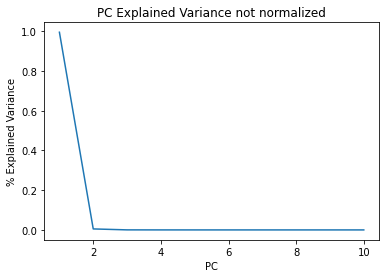

In [7]:
plt.title("PC Explained Variance not normalized")
ratios = pca.explained_variance_ratio_
plt.plot(list(range(1,len(ratios)+1)), ratios)
plt.xlabel("PC")
plt.ylabel("% Explained Variance")
plt.show()

In [8]:
from sklearn import preprocessing

#PCA with normalization
scaler = preprocessing.StandardScaler().fit(numeric)
numeric_scaled = scaler.transform(numeric)

pca_scaled = PCA(n_components=len(list(numeric.columns)))
transformed = pca_scaled.fit_transform(numeric_scaled)
print(pca_scaled.explained_variance_ratio_)

[0.25888209 0.17681467 0.14612703 0.10066557 0.09902073 0.08802628
 0.07512741 0.04396447 0.00623165 0.00514011]


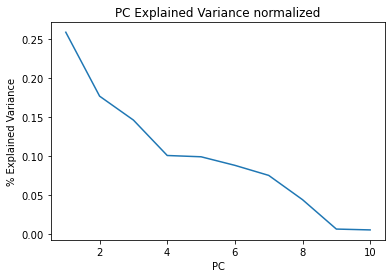

In [9]:
plt.title("PC Explained Variance normalized")
ratios_scaled = pca_scaled.explained_variance_ratio_
plt.plot(list(range(1,len(ratios)+1)), ratios_scaled)
plt.xlabel("PC")
plt.ylabel("% Explained Variance")
plt.show()

In [10]:
numeric_scaled.argmax(), numeric_scaled.max()

(34160, 62.96329842652637)

In [39]:
no_outlier_first = numeric_scaled[:34160//len(numeric_scaled),:]
no_outlier_last = numeric_scaled[34160//len(numeric_scaled)+1:,:]
no_outlier = np.concatenate((no_outlier_first, no_outlier_last))
no_outlier.shape

(8341, 10)

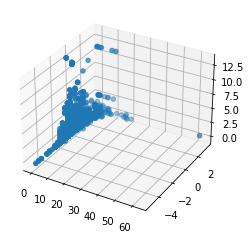

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(no_outlier[:,0], no_outlier[:,1], no_outlier[:,2])

# Modeling Data 

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier